# DNSM branch lengths: why do they get long sometimes?

Here we show that very long branch lengths only happen when we have triple mutations in a given codon, which is rare.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from netam.framework import load_crepe
from epam.sequences import translate_sequence, mutation_frequency
sys.path.append('..')
from dnsmex.dxsm_data import data_of_nickname

Using Metal Performance Shaders


In [2]:
dataset_name = "tang60"
pcp_df, train_dataset, val_dataset = data_of_nickname(dataset_name)

Loading /Users/matsen/data/tang-deepshm-prod_pcp_2023-11-30_MASKED_NI_IGHV34_noN_first60K.shmple.hdf5
consolidating shmple rates into substitution probabilities...
consolidating shmple rates into substitution probabilities...
we have 48000 training examples and 12000 validation examples


In [3]:
our_df = pcp_df.drop(columns=['rates', 'subs_probs'])
our_df["mut_freq"] = [mutation_frequency(p, c) for p, c in zip(our_df["parent"], our_df["child"])]

In [4]:
def max_codon_diffs(parent_seq, child_seq):
    assert len(parent_seq) == len(child_seq), "Parent and child sequences must be of equal length."
    assert len(parent_seq) % 3 == 0, "Sequence length must be a multiple of 3."

    max_diffs = 0

    for i in range(0, len(parent_seq), 3):
        parent_codon = parent_seq[i:i+3]
        child_codon = child_seq[i:i+3]

        # Count the number of differences in the codon
        diffs = sum(1 for pc, cc in zip(parent_codon, child_codon) if pc != cc)
        max_diffs = max(max_diffs, diffs)

    return max_diffs

# Example usage on a single pair of sequences
parent_seq = "TTGCGTACGTTA"
child_seq =  "ATGCGTACGCTA"
assert max_codon_diffs(parent_seq, child_seq) == 1

our_df['max_codon_diffs'] = our_df.apply(lambda row: max_codon_diffs(row['parent'], row['child']), axis=1)

In [5]:
train_df = our_df.head(len(train_dataset)).copy()
train_bls = pd.read_csv("_ignore/dnsm_sml-tang60-joint.train_branch_lengths.csv")
assert len(train_df) == len(train_bls)
train_df["branch_length"] = train_bls

In [6]:
train_df.sort_values(by="branch_length", inplace=True)
train_df

,sample_id,family,parent,child,branch_length,v_gene,child_is_leaf,v_family,mut_freq,max_codon_diffs
46969,CLL1697,68357,GAGGTGCGACTAGTGGAGTCTGGGGGAGACTTAGTCCAGCCTGGGG...,GAGGTGCGACTAGTGGAGTCTGGGGGAGACTTAGTCCAGCCTGGGG...,0.020996,IGHV3-48*01,False,IGHV3,0.002667,1
44465,CLL1697,33012,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCCTGGTCAAGCCTGGGG...,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCCTGGTCAAGCCTGGGG...,0.021625,IGHV3-21*01,False,IGHV3,0.002755,1
43952,CLL2056,6513,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,0.021946,IGHV3-48*02,False,IGHV3,0.002778,1
21029,CLL1374,10698,GAGGTGCAACTGGTGGAGTCTGGGGGAGGCCTGGTCAAGCCTGGGG...,GAGGTGCAACTGGTGGAGTCTGGGGGAGGCCTGGTCAAGCCTGGGG...,0.022155,IGHV3-21*01,True,IGHV3,0.002755,1
13955,CLL1374,6329,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,0.022384,IGHV3-30*03,True,IGHV3,0.002778,1
...,...,...,...,...,...,...,...,...,...,...
3261,CLL1374,16509,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,27.701589,IGHV3-30*03,False,IGHV3,0.008130,3
3890,CLL1374,15756,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGAG...,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGAG...,27.852631,IGHV3-48*03,False,IGHV3,0.008130,3
40082,CLL2056,14851,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,32.181571,IGHV3-30*18,True,IGHV3,0.016393,3
7124,CLL1374,23407,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,40.489165,IGHV3-30*03,False,IGHV3,0.007874,3


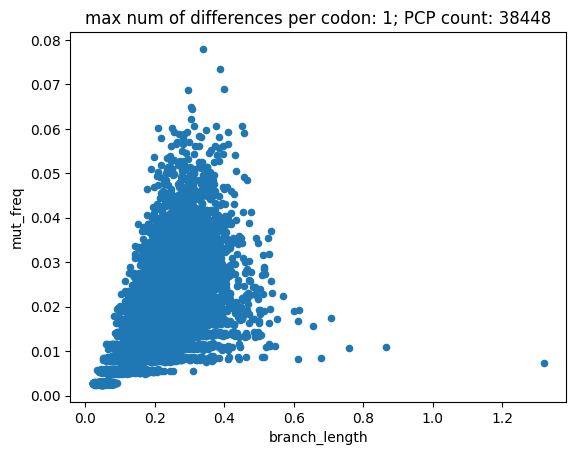

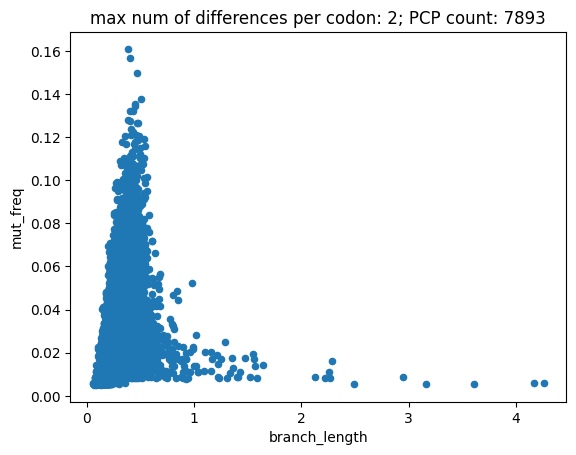

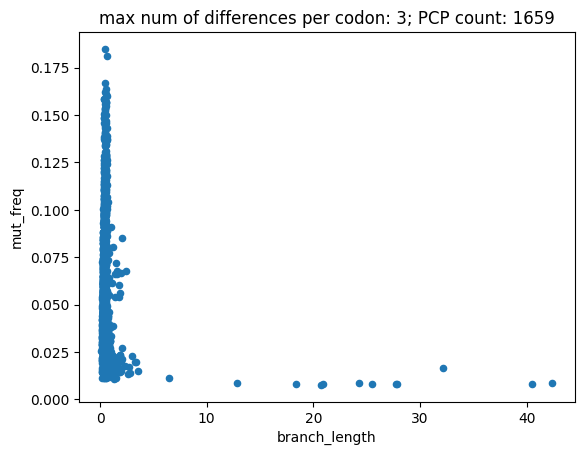

In [7]:
for diff_count, group in train_df.groupby("max_codon_diffs"):
    group.plot.scatter(x="branch_length", y="mut_freq", title=f"max num of differences per codon: {diff_count}; PCP count: {len(group)}")

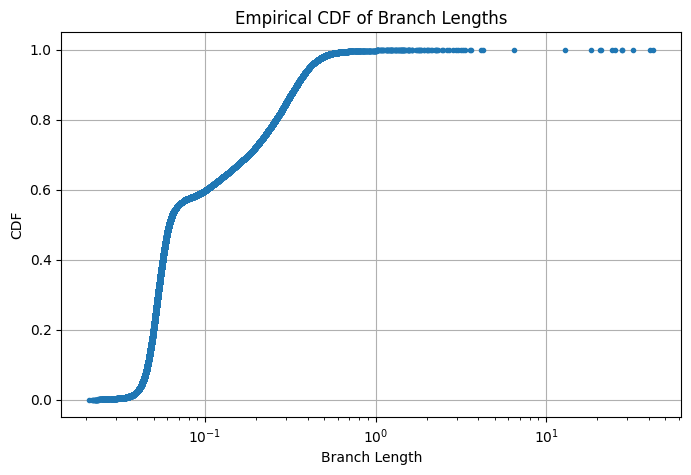

In [8]:
branch_lengths = train_df["branch_length"]

sorted_data = np.sort(branch_lengths)
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.figure(figsize=(8, 5))
plt.plot(sorted_data, cdf, marker='.', linestyle='none')
plt.xscale('log')
plt.xlabel('Branch Length')
plt.ylabel('CDF')
plt.title('Empirical CDF of Branch Lengths')
plt.grid(True)
plt.show()


In [9]:
long_idx = 41677
long_parent = train_df.loc[long_idx, "parent"]
long_child = train_df.loc[long_idx, "child"]

In [10]:
import pandas as pd
from Bio.Seq import Seq

def differing_codons(parent_seq, child_seq):
    assert len(parent_seq) == len(child_seq), "Parent and child sequences must be of equal length."
    assert len(parent_seq) % 3 == 0, "Sequence length must be a multiple of 3."

    differing_codons = []

    for i in range(0, len(parent_seq), 3):
        parent_codon = parent_seq[i:i+3]
        child_codon = child_seq[i:i+3]

        if parent_codon != child_codon:
            parent_aa = str(Seq(parent_codon).translate())
            child_aa = str(Seq(child_codon).translate())

            differing_codons.append({
                'nt_position': i,
                'aa_position': i//3,
                'parent_codon': parent_codon,
                'child_codon': child_codon,
                'parent_aa': parent_aa,
                'child_aa': child_aa
            })

    return pd.DataFrame(differing_codons)

differing_codons(long_parent, long_child)


,nt_position,aa_position,parent_codon,child_codon,parent_aa,child_aa
0,297,99,CCC,GGT,P,G


In [11]:
crepe = load_crepe("_ignore/dnsm_sml-tang60-joint")
model = crepe.model

In [12]:
long_parent_aa = translate_sequence(long_parent)
model.selection_factors_of_aa_str(long_parent_aa)[99]

tensor(0.9071)

In [13]:
long_row = pcp_df.loc[long_idx]
assert long_row["parent"] == long_parent
long_rates = long_row["rates"]
long_subs_probs = long_row["subs_probs"]
long_rates[297:300], long_subs_probs[297:300]

(tensor([0.1425, 0.2543, 0.2941]),
 tensor([[2.0690e-01, 6.7732e-05, 1.5871e-01, 6.3432e-01],
         [2.2074e-01, 7.7052e-05, 2.4701e-01, 5.3217e-01],
         [1.8950e-01, 6.3496e-05, 3.7091e-01, 4.3952e-01]]))

<Axes: >

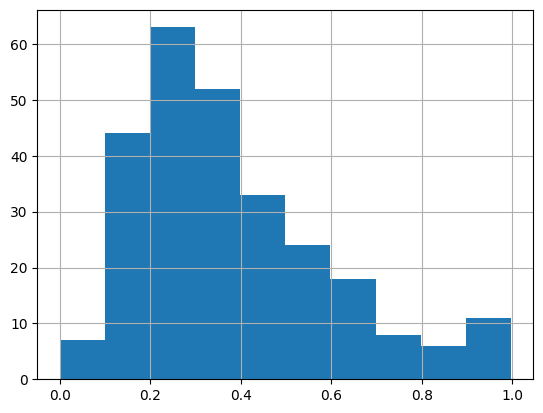

In [14]:
rates_series = pd.Series(long_rates.numpy())
rates_series = rates_series[rates_series < 1]
rates_series.hist()

So it seems that the really long branch lengths come from having a collection of 3 relatively immutable sites.